In [1]:
import sys

In [2]:
!{sys.executable} -m pip install sagemaker-experiments

  Using cached sagemaker_experiments-0.1.19-py3-none-any.whl (35 kB)


In [3]:
!{sys.executable} -m pip install torch
!{sys.executable} -m pip install torchvision

     |████████████████████████████████| 753.2 MB 906 bytes/s a 0:00:01    |█▍                              | 33.8 MB 12.9 MB/s eta 0:00:56     |████████████████████▍           | 479.7 MB 56.9 MB/s eta 0:00:05
     |████████████████████████████████| 6.6 MB 12.1 MB/s eta 0:00:01


In [4]:
import time

import boto3
import numpy as np
import pandas as pd
%config InlineBackend.figure_format = 'retina'
from matplotlib import pyplot as plt
from torchvision import datasets, transforms

import sagemaker
from sagemaker import get_execution_role
from sagemaker.session import Session
from sagemaker.analytics import ExperimentAnalytics

from smexperiments.experiment import Experiment
from smexperiments.trial import Trial
from smexperiments.trial_component import TrialComponent
from smexperiments.tracker import Tracker

In [5]:
sess = boto3.Session()
sm = sess.client('sagemaker')
role = get_execution_role()

In [6]:
# create a s3 bucket to hold data, note that your account might already created a bucket with the same name
account_id = sess.client('sts').get_caller_identity()["Account"]
bucket = 'sagemaker-experiments-{}-{}'.format(sess.region_name, account_id)
prefix = 'mnist'

try:
    if sess.region_name == "us-east-1":
        sess.client('s3').create_bucket(Bucket=bucket)
    else:
        sess.client('s3').create_bucket(Bucket=bucket, 
                                        CreateBucketConfiguration={'LocationConstraint': sess.region_name})
except Exception as e:
    print(e)

In [7]:
# download the dataset
# this will not only download data to ./mnist folder, but also load and transform (normalize) them
train_set = datasets.MNIST('mnist', train=True, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))]), 
    download=True)
                           
test_set = datasets.MNIST('mnist', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))]),
    download=False)

Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw


Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw




Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw
Processing...


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


Done!


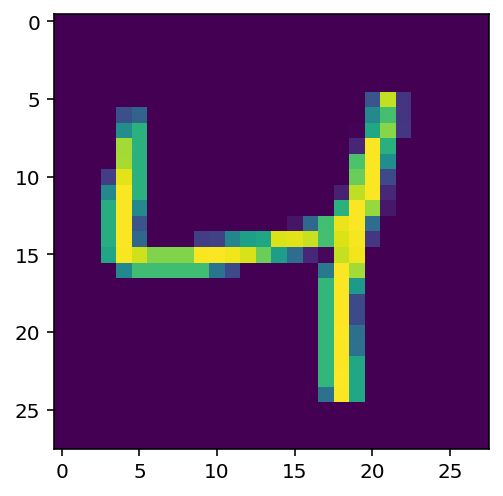

In [8]:
plt.imshow(train_set.data[2].numpy())

After transforming the images in the dataset, we upload it to s3.

In [9]:
inputs = sagemaker.Session().upload_data(path='mnist', bucket=bucket, key_prefix=prefix)
print('input spec: {}'.format(inputs))

input spec: s3://sagemaker-experiments-eu-west-1-402345010737/mnist


In [10]:
with Tracker.create(display_name="Preprocessing", sagemaker_boto_client=sm) as tracker:
    tracker.log_parameters({
        "normalization_mean": 0.1307,
        "normalization_std": 0.3081,
    })
    # we can log the s3 uri to the dataset we just uploaded
    tracker.log_input(name="mnist-dataset", media_type="s3/uri", value=inputs)

In [11]:
mnist_experiment = Experiment.create(
    experiment_name=f"mnist-hand-written-digits-classification-{int(time.time())}", 
    description="Classification of mnist hand-written digits", 
    sagemaker_boto_client=sm)
print(mnist_experiment)

Experiment(sagemaker_boto_client=<botocore.client.SageMaker object at 0x7f283e033090>,experiment_name='mnist-hand-written-digits-classification-1594731918',description='Classification of mnist hand-written digits',tags=None,experiment_arn='arn:aws:sagemaker:eu-west-1:402345010737:experiment/mnist-hand-written-digits-classification-1594731918',response_metadata={'RequestId': 'd451ec80-e266-4358-a706-843e3bb9d8ce', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'd451ec80-e266-4358-a706-843e3bb9d8ce', 'content-type': 'application/x-amz-json-1.1', 'content-length': '123', 'date': 'Tue, 14 Jul 2020 13:05:18 GMT'}, 'RetryAttempts': 0})


In [12]:
from sagemaker.pytorch import PyTorch

In [13]:
hidden_channel_trial_name_map = {}

In [14]:
preprocessing_trial_component = tracker.trial_component

In [15]:
for i, num_hidden_channel in enumerate([2, 5, 10, 20, 32]):
    # create trial
    trial_name = f"cnn-training-job-{num_hidden_channel}-hidden-channels-{int(time.time())}"
    cnn_trial = Trial.create(
        trial_name=trial_name, 
        experiment_name=mnist_experiment.experiment_name,
        sagemaker_boto_client=sm,
    )
    hidden_channel_trial_name_map[num_hidden_channel] = trial_name
    
    # associate the proprocessing trial component with the current trial
    cnn_trial.add_trial_component(preprocessing_trial_component)
    
    # all input configurations, parameters, and metrics specified in estimator 
    # definition are automatically tracked
    estimator = PyTorch(
        entry_point='./mnist.py',
        role=role,
        sagemaker_session=sagemaker.Session(sagemaker_client=sm),
        framework_version='1.1.0',
        train_instance_count=1,
        train_instance_type='ml.c4.xlarge',
        hyperparameters={
            'epochs': 2,
            'backend': 'gloo',
            'hidden_channels': num_hidden_channel,
            'dropout': 0.2,
            'optimizer': 'sgd'
        },
        metric_definitions=[
            {'Name':'train:loss', 'Regex':'Train Loss: (.*?);'},
            {'Name':'test:loss', 'Regex':'Test Average loss: (.*?),'},
            {'Name':'test:accuracy', 'Regex':'Test Accuracy: (.*?)%;'}
        ],
        enable_sagemaker_metrics=True,
    )
    
    cnn_training_job_name = "cnn-training-job-{}".format(int(time.time()))
    
    # Now associate the estimator with the Experiment and Trial
    estimator.fit(
        inputs={'training': inputs}, 
        job_name=cnn_training_job_name,
        experiment_config={
            "TrialName": cnn_trial.trial_name,
            "TrialComponentDisplayName": "Training",
        },
        wait=True,
    )
    
    # give it a while before dispatching the next training job
    time.sleep(2)

INFO:sagemaker:Created S3 bucket: sagemaker-eu-west-1-402345010737
INFO:sagemaker:Creating training-job with name: cnn-training-job-1594732318


2020-07-14 13:11:59 Starting - Starting the training job...
2020-07-14 13:12:04 Starting - Launching requested ML instances.........
2020-07-14 13:13:37 Starting - Preparing the instances for training......
2020-07-14 13:14:55 Downloading - Downloading input data...
2020-07-14 13:15:23 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-07-14 13:15:24,683 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-07-14 13:15:24,686 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-14 13:15:24,698 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-07-14 13:15:26,110 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-07-14 13:15:26,376 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating s

INFO:sagemaker:Creating training-job with name: cnn-training-job-1594732605


2020-07-14 13:16:45 Starting - Starting the training job...
2020-07-14 13:16:47 Starting - Launching requested ML instances.........
2020-07-14 13:18:36 Starting - Preparing the instances for training......
2020-07-14 13:19:36 Downloading - Downloading input data...
2020-07-14 13:20:09 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-07-14 13:20:10,151 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-07-14 13:20:10,153 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-14 13:20:10,165 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-07-14 13:20:13,180 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-07-14 13:20:13,450 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating s

INFO:sagemaker:Creating training-job with name: cnn-training-job-1594732891


2020-07-14 13:21:31 Starting - Starting the training job...
2020-07-14 13:21:33 Starting - Launching requested ML instances......
2020-07-14 13:22:41 Starting - Preparing the instances for training......
2020-07-14 13:23:52 Downloading - Downloading input data...
2020-07-14 13:24:31 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-07-14 13:24:33,810 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-07-14 13:24:33,813 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-14 13:24:33,824 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-07-14 13:24:34,439 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-07-14 13:24:34,936 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating setu

INFO:sagemaker:Creating training-job with name: cnn-training-job-1594733176


2020-07-14 13:26:16 Starting - Starting the training job...
2020-07-14 13:26:18 Starting - Launching requested ML instances......
2020-07-14 13:27:26 Starting - Preparing the instances for training......
2020-07-14 13:28:35 Downloading - Downloading input data
2020-07-14 13:28:35 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-07-14 13:28:56,464 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-07-14 13:28:56,467 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-14 13:28:56,478 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-07-14 13:28:59,491 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-07-14 13:28:59,817 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating setup.py
2020-07-14 13:28:59,818

INFO:sagemaker:Creating training-job with name: cnn-training-job-1594733431


2020-07-14 13:30:31 Starting - Starting the training job...
2020-07-14 13:30:33 Starting - Launching requested ML instances.........
2020-07-14 13:32:05 Starting - Preparing the instances for training...
2020-07-14 13:32:59 Downloading - Downloading input data...
2020-07-14 13:33:28 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-07-14 13:33:44,197 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-07-14 13:33:44,200 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-07-14 13:33:44,212 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-07-14 13:33:47,233 sagemaker_pytorch_container.training INFO     Invoking user training script.
2020-07-14 13:33:47,578 sagemaker-containers INFO     Module mnist does not provide a setup.py. 
Generating setup.py
2020-07-14 13:33:47,

In [16]:
search_expression = {
    "Filters":[
        {
            "Name": "DisplayName",
            "Operator": "Equals",
            "Value": "Training",
        }
    ],
}

In [17]:
trial_component_analytics = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm), 
    experiment_name=mnist_experiment.experiment_name,
    search_expression=search_expression,
    sort_by="metrics.test:accuracy.max",
    sort_order="Descending",
    metric_names=['test:accuracy'],
    parameter_names=['hidden_channels', 'epochs', 'dropout', 'optimizer']
)

In [18]:
trial_component_analytics.dataframe()

,TrialComponentName,DisplayName,SourceArn,dropout,epochs,hidden_channels,optimizer,test:accuracy - Min,test:accuracy - Max,test:accuracy - Avg,test:accuracy - StdDev,test:accuracy - Last,test:accuracy - Count
0,cnn-training-job-1594733431-aws-training-job,Training,arn:aws:sagemaker:eu-west-1:402345010737:train...,0.2,2.0,32.0,"""sgd""",95.0,97.0,96.0,1.414214,97.0,2
1,cnn-training-job-1594732318-aws-training-job,Training,arn:aws:sagemaker:eu-west-1:402345010737:train...,0.2,2.0,2.0,"""sgd""",95.0,97.0,96.0,1.414214,97.0,2
2,cnn-training-job-1594732891-aws-training-job,Training,arn:aws:sagemaker:eu-west-1:402345010737:train...,0.2,2.0,10.0,"""sgd""",95.0,97.0,96.0,1.414214,97.0,2
3,cnn-training-job-1594733176-aws-training-job,Training,arn:aws:sagemaker:eu-west-1:402345010737:train...,0.2,2.0,20.0,"""sgd""",96.0,97.0,96.5,0.707107,97.0,2
4,cnn-training-job-1594732605-aws-training-job,Training,arn:aws:sagemaker:eu-west-1:402345010737:train...,0.2,2.0,5.0,"""sgd""",94.0,96.0,95.0,1.414214,96.0,2


To isolate and measure the impact of change in hidden channels on model accuracy, we vary the number of hidden channel and fix the value for other hyperparameters.

Next let's look at an example of tracing the lineage of a model by accessing the data tracked by SageMaker Experiments for `cnn-training-job-2-hidden-channels` trial

In [19]:
lineage_table = ExperimentAnalytics(
    sagemaker_session=Session(sess, sm), 
    search_expression={
        "Filters":[{
            "Name": "Parents.TrialName",
            "Operator": "Equals",
            "Value": hidden_channel_trial_name_map[2]
        }]
    },
    sort_by="CreationTime",
    sort_order="Ascending",
)

In [20]:
lineage_table.dataframe()

,TrialComponentName,DisplayName,normalization_mean,normalization_std,SourceArn,SageMaker.ImageUri,SageMaker.InstanceCount,SageMaker.InstanceType,SageMaker.VolumeSizeInGB,backend,...,test:accuracy - Avg,test:accuracy - StdDev,test:accuracy - Last,test:accuracy - Count,train:loss - Min,train:loss - Max,train:loss - Avg,train:loss - StdDev,train:loss - Last,train:loss - Count
0,TrialComponent-2020-07-14-130148-vnzt,Preprocessing,0.1307,0.3081,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cnn-training-job-1594732318-aws-training-job,Training,NaN,NaN,arn:aws:sagemaker:eu-west-1:402345010737:train...,520713654638.dkr.ecr.eu-west-1.amazonaws.com/s...,1.0,ml.c4.xlarge,30.0,"""gloo""",...,96.0,1.414214,97.0,2.0,0.157259,1.617049,0.456703,0.352488,0.157259,18.0
